### Do I need to implement the GPU version for faster computation?

In [1]:
import numpy as np
import scipy.io as io
from torch.autograd import grad
from utils import *

In [2]:
DATA_PATH = "/Users/pongpisit/Desktop/research/pinn/Solving-Differential-Equations-with-Neural-Networks/SymbolicMathematics/data/burgers_shock.mat"
data = io.loadmat(DATA_PATH)

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

N = 2000
print(f"Training with {N} samples")
idx = np.random.choice(X_star.shape[0], N, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx,:]

# Convert to torch.tensor
X_u_train = torch.tensor(X_u_train).float().requires_grad_(True)
u_train = torch.tensor(u_train).float().requires_grad_(True)
X_star = torch.tensor(X_star).float().requires_grad_(True)
u_star = torch.tensor(u_star).float().requires_grad_(True)

Training with 2000 samples


In [3]:
class Network(nn.Module):
    def __init__(self, model):
        super(Network, self).__init__()
        self.model = model
#         self.model.apply(self.xavier_init)
        # For tracking
        self.index2features = ('uf', 'u_x',  'u_xx', 'u_tt', 'u_xt', 'u_tx')
        self.uf = None
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, x, t):
        self.uf = self.model(torch.cat([x, t], dim=1))
        return self.uf
    
    def get_selector_data(self, x, t):
        uf = self.forward(x, t)
        
        ### PDE Loss calculation ###
        # first-order derivatives
        u_t = self.gradients(uf, t)[0]
        u_x = self.gradients(uf, x)[0]
        # Homo second-order derivatives
        u_tt = self.gradients(u_t,t)[0]
        u_xx = self.gradients(u_x, x)[0]
        # Hetero second-order derivatives
        u_xt = self.gradients(u_t, x)[0]
        u_tx = self.gradients(u_x, t)[0]
        
        X_selector = torch.cat([uf, u_x, u_xx, u_tt, u_xt, u_tx], dim=1)
        y_selector = u_t
        
        return X_selector, y_selector
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones(func.shape))

In [4]:
# Does the SeclectorNetwork has to be a neural networks ???
class SeclectorNetwork(nn.Module):
    def __init__(self, X_train_dim):
        super().__init__()
        # Nonlinear model, Training with noisy features -> chk feature importance
        layers = [nn.Linear(X_train_dim, 50), nn.Tanh(), nn.Linear(50, 1)]
        self.nonlinear_model = nn.Sequential(*layers)
        
    def forward(self, inn):
        ut_approx = self.nonlinear_model(inn)
        return ut_approx
    
    def loss(self, X_input, y_input):
        ut_approx = self.forward(X_input)
        mse_loss = F.mse_loss(ut_approx, y_input, reduction='mean')
        return mse_loss

In [5]:
network = Network(model=simple_solver_model(50))
selector = SeclectorNetwork(X_train_dim=6)

optimizer = torch.optim.LBFGS(list(network.parameters()) + list(selector.parameters()), 
                              lr=5e-2, max_iter=80, max_eval=100, 
                              history_size=120, line_search_fn='strong_wolfe')

# optimizer = torch.optim.Adam(list(network.parameters()) + list(selector.parameters()), lr=1e-3)
epochs = 5000; testing = False

if testing:
    # unsupervised_loss
    unsup_loss = selector.loss(*network.get_selector_data(*dimension_slicing(X_u_train)))
    sup_loss = F.mse_loss(network.uf, u_train)

    # No MTL yet, apply the naive summation first to see if it's working?
    total_loss = unsup_loss + sup_loss
    print(total_loss)

    total_loss.backward()

In [6]:
network.train(); selector.train(); best_train_loss = 1e6

for i in range(epochs):
    def closure():
        optimizer.zero_grad()

        # Total loss calculation process
        # unsupervised_loss
        unsup_loss = selector.loss(*network.get_selector_data(*dimension_slicing(X_u_train)))
        sup_loss = F.mse_loss(network.uf, u_train)

        # No MTL yet, apply the naive summation first to see if it's working?
        total_loss = unsup_loss + sup_loss
        total_loss.backward()
        
        return total_loss
    
    optimizer.step(closure)
    
    l = closure()
    
    if (i % 10) == 0:
        print("Epoch {}: ".format(i), l.item())

Epoch 0:  0.0391339510679245
Epoch 10:  0.010887873359024525
Epoch 20:  0.008779932744801044
Epoch 30:  0.006546802818775177
Epoch 40:  0.005111404694616795
Epoch 50:  0.004613327328115702
Epoch 60:  0.004308655858039856
Epoch 70:  0.0041819061152637005
Epoch 80:  0.0041819061152637005
Epoch 90:  0.0041819061152637005
Epoch 100:  0.0041819061152637005
Epoch 110:  0.0041819061152637005
Epoch 120:  0.0041819061152637005
Epoch 130:  0.0041819061152637005
Epoch 140:  0.0041819061152637005
Epoch 150:  0.0041819061152637005
Epoch 160:  0.0041819061152637005
Epoch 170:  0.0041819061152637005
Epoch 180:  0.0041819061152637005
Epoch 190:  0.0041819061152637005
Epoch 200:  0.0041819061152637005
Epoch 210:  0.0041819061152637005


KeyboardInterrupt: 

In [7]:
network.eval()
F.mse_loss(network(*dimension_slicing(X_star)).detach(), u_star)

tensor(0.0036, grad_fn=<MseLossBackward>)

In [10]:
import shap
X_selector, y_selector = network.get_selector_data(*dimension_slicing(X_u_train))
e = shap.DeepExplainer(selector, X_selector)

In [12]:
shap_values = e.shap_values(X_selector)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [15]:
import pandas as pd
df = pd.DataFrame({
    "mean_abs_shap": np.mean(np.abs(shap_values), axis=0), 
    "stdev_abs_shap": np.std(np.abs(shap_values), axis=0), 
    "name": ['uf', 'u_x',  'u_xx', 'u_tt', 'u_xt', 'u_tx']
})
df.sort_values("mean_abs_shap", ascending=False)[:10]

,mean_abs_shap,stdev_abs_shap,name
0,0.475227,0.248167,uf
2,0.192460,0.440518,u_xx
5,0.135427,0.257663,u_tx
1,0.126486,0.325671,u_x
4,0.096400,0.119796,u_xt
3,0.055789,0.041418,u_tt


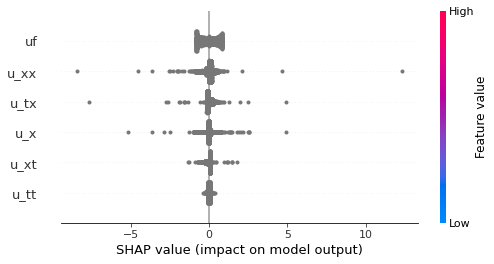

In [17]:
shap.summary_plot(shap_values, features=X_selector, feature_names=['uf', 'u_x',  'u_xx', 'u_tt', 'u_xt', 'u_tx'])